# 05 – Active City Index für München

Ziel dieses Notebooks:

- Zusammenführung aller vorbereiteten Stadtbezirks-Datensätze  
  (Bevölkerung, Parks, Sport, Mobility/ÖPNV + Radwege)
- Erstellung eines einheitlichen Analyse-GeoDataFrames `gdf_active`
- Definition und Normalisierung ausgewählter Indikatoren
- Berechnung eines ersten modularen Active-City-Index (MVP) auf Bezirksebene
- Erste Visualisierung des Index (Histogramm, Ranking und Choroplethenkarte)
- Export des Analyse-Datensatzes für weitere Schritte und Berichtsarbeit

In [52]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

BASE_DIR, INTERIM_DIR, PROCESSED_DIR


(PosixPath('..'), PosixPath('../data/interim'), PosixPath('../data/processed'))

## A | Datenintegration & Indexkonstruktion

### Datenquellen Laden

Wir laden die vorbereiteten Layer:

- `muc_bezirke_bev_clean.geojson` (Bezirke + Bevölkerung + Fläche)
- `muc_bezirke_parks.geojson` (Parks je Bezirk)
- `muc_bezirke_sport.geojson` (Sportstätten je Bezirk)
- `muc_bezirke_mobility.geojson` (ÖPNV-Haltestellen und Radwege je Bezirk)

In [53]:
# Basis: Bezirke + Bevölkerung + Fläche
gdf_base = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")

# Parks
gdf_parks = gpd.read_file(PROCESSED_DIR / "muc_bezirke_parks.geojson")[[
    "bez_nr",
    "parks_count",
    "parks_area_ha",
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent"
]]

# Sport
gdf_sport = gpd.read_file(PROCESSED_DIR / "muc_bezirke_sport.geojson")[[
    "bez_nr",
    "sports_count",
    "sports_area_ha",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent"
]]

# Mobility (ÖPNV + Radwege)
gdf_mob = gpd.read_file(PROCESSED_DIR / "muc_bezirke_mobility.geojson")[[
    "bez_nr",
    "stops_count",
    "stops_pro_1000_einw",
    "radweg_length_m",
    "radweg_km",
    "radweg_km_pro_km2"
]]


In [87]:
gdf_base.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bez_nr           25 non-null     int32   
 1   name             25 non-null     object  
 2   stadtbezirk      25 non-null     object  
 3   einwohner        25 non-null     int32   
 4   flaeche_ha       25 non-null     float64 
 5   einwohnerdichte  25 non-null     int32   
 6   geometry         25 non-null     geometry
dtypes: float64(1), geometry(1), int32(3), object(2)
memory usage: 1.2+ KB


In [90]:
gdf_parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bez_nr                     25 non-null     int32  
 1   parks_count                25 non-null     int32  
 2   parks_area_ha              25 non-null     float64
 3   parks_pro_1000_einw        25 non-null     float64
 4   parks_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [91]:
gdf_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bez_nr                      25 non-null     int32  
 1   sports_count                25 non-null     int32  
 2   sports_area_ha              25 non-null     float64
 3   sports_pro_1000_einw        25 non-null     float64
 4   sports_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [92]:
gdf_mob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bez_nr               25 non-null     int32  
 1   stops_count          25 non-null     int32  
 2   stops_pro_1000_einw  25 non-null     float64
 3   radweg_length_m      25 non-null     float64
 4   radweg_km            25 non-null     float64
 5   radweg_km_pro_km2    25 non-null     float64
dtypes: float64(4), int32(2)
memory usage: 1.1 KB


### Zusammenführung zum Analyse-Datensatz `gdf_active`

Die Einzel-Datensätze werden über den Bezirksschlüssel `bez_nr` zusammengeführt.
NaN-Werte in Kennzahlen-Spalten werden als 0 interpretiert (z. B. Bezirke ohne Parks/Sportstätten).


In [58]:
gdf_active = (
    gdf_base
    .merge(gdf_parks, on="bez_nr", how="left")
    .merge(gdf_sport, on="bez_nr", how="left")
    .merge(gdf_mob,   on="bez_nr", how="left")
)

kennzahl_spalten = [
    "parks_count", "parks_area_ha", "parks_pro_1000_einw", "parks_area_anteil_prozent",
    "sports_count", "sports_area_ha", "sports_pro_1000_einw", "sports_area_anteil_prozent",
    "stops_count", "stops_pro_1000_einw",
    "radweg_length_m", "radweg_km", "radweg_km_pro_km2"
]

for col in kennzahl_spalten:
    gdf_active[col] = gdf_active[col].fillna(0)

gdf_active[[
    "bez_nr", "name", "einwohner",
    "parks_pro_1000_einw",
    "sports_pro_1000_einw",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2"
]].head()

,bez_nr,name,einwohner,parks_pro_1000_einw,sports_pro_1000_einw,stops_pro_1000_einw,radweg_km_pro_km2
0,1,Altstadt-Lehel,20876,1.293351,0.910136,8.478636,0.079506
1,2,Ludwigsvorstadt-Isarvorstadt,50081,0.419321,0.738803,6.629261,0.076943
2,3,Maxvorstadt,52434,0.667506,0.858222,3.642675,0.065135
3,4,Schwabing-West,68610,0.335228,0.816208,2.565224,0.086087
4,5,Au-Haidhausen,63972,0.562746,1.031701,3.923592,0.072198


### Konfiguration der Index-Dimensionen und Indikatoren

Der Active City Index soll modular aufgebaut sein.  
Dazu definieren wir für jede Dimension eine Liste an Indikator-Spalten:

- **Grün & Erholung**
- **Sportinfrastruktur**
- **Mobilität (ÖPNV + Radwege)**

Die Listen können später leicht angepasst oder erweitert werden.

In [60]:
# Grün & Erholung
GREEN_INDICATORS = [
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
]

# Sportinfrastruktur
SPORT_INDICATORS = [
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
]

# Mobilität (ÖPNV + Radwege)
MOBILITY_INDICATORS = [
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]

# Alle verwendeten Indikatoren in einer Liste sammeln (für Normalisierung)
ALL_INDICATORS = list(set(
    GREEN_INDICATORS + SPORT_INDICATORS + MOBILITY_INDICATORS
))

ALL_INDICATORS

['parks_pro_1000_einw',
 'parks_area_anteil_prozent',
 'sports_pro_1000_einw',
 'sports_area_anteil_prozent',
 'stops_pro_1000_einw',
 'radweg_km_pro_km2']

### Index Engine mit parametrisierter Normalisierung & Gewichten

In [ ]:
# Normalisierungsfunktion
def normalize_series(x, method="minmax"):
    if method == "minmax":
        return (x - x.min()) / (x.max() - x.min())
    elif method == "zscore":
        return (x - x.mean()) / x.std()
    else:
        raise ValueError("Unknown method")

In [ ]:
# Funktion zur Berechnung des Active City Index
def compute_active_city_index(
    gdf,
    green_ind,
    sport_ind,
    mob_ind,
    weights=None,
    norm_method="minmax"
):
    if weights is None:
        weights = {"green": 1/3, "sport": 1/3, "mob": 1/3}

    all_inds = list(set(green_ind + sport_ind + mob_ind))

    # 1) Normalisierung
    for col in all_inds:
        col_norm = col + "_norm"
        gdf[col_norm] = normalize_series(gdf[col], method=norm_method)

    # 2) Teilindizes
    gdf["index_gruen"] = gdf[[c + "_norm" for c in green_ind]].mean(axis=1)
    gdf["index_sport"] = gdf[[c + "_norm" for c in sport_ind]].mean(axis=1)
    gdf["index_mobil"] = gdf[[c + "_norm" for c in mob_ind]].mean(axis=1)

    # 3) Gesamtindex
    gdf["active_city_index"] = (
        weights["green"] * gdf["index_gruen"] +
        weights["sport"] * gdf["index_sport"] +
        weights["mob"]   * gdf["index_mobil"]
    )
    return gdf

Best Practice aus OECD:

### Index mit gleichen Gewichten

In [144]:
active_index = compute_active_city_index(
    gdf_active,
    GREEN_INDICATORS,
    SPORT_INDICATORS,
    MOBILITY_INDICATORS,
    weights={"green": 1/3, "sport": 1/3, "mob": 1/3}
)

In [145]:
cols = [
    "bez_nr",
    "name",
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil"
]

active_index[cols] \
    .sort_values("active_city_index", ascending=False) \
    .reset_index(drop=True) \
    .head(25)   


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.748611,0.600404,0.717211,0.928220
1,1,Altstadt-Lehel,0.619496,1.000000,0.147792,0.710697
2,22,Aubing-Lochhausen-Langwied,0.562677,0.248681,0.809060,0.630289
3,15,Trudering-Riem,0.520589,0.415931,0.753536,0.392299
4,11,Milbertshofen-Am Hart,0.499102,0.178740,0.906610,0.411955
5,12,Schwabing-Freimann,0.441562,0.227074,0.721758,0.375853
6,6,Sendling,0.423638,0.247197,0.637222,0.386494
7,18,Untergiesing-Harlaching,0.419489,0.314777,0.617093,0.326596
8,10,Moosach,0.414712,0.284329,0.541466,0.418340
9,7,Sendling-Westpark,0.392968,0.209595,0.630089,0.339219


## B | Auswertung & Visualisierung

### Erste Auswertung des Active City Index

Zur Einordnung des Index betrachten wir:

- die Verteilung der Indexwerte über alle Stadtbezirke (Histogramm)
- ein Ranking der Bezirke (Top/Bottom-Bezirke)

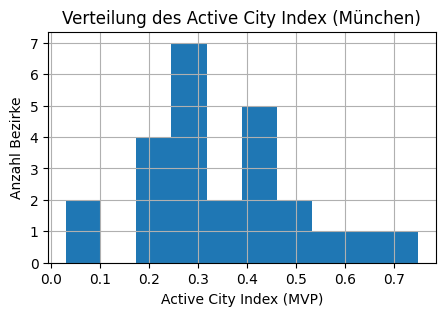

In [146]:
plt.figure(figsize=(5, 3))
active_index["active_city_index"].hist(bins=10)
plt.xlabel("Active City Index (MVP)")
plt.ylabel("Anzahl Bezirke")
plt.title("Verteilung des Active City Index (München)")
plt.show()

In [118]:

ranking = (
    active_index[cols]
    .sort_values("active_city_index", ascending=False)
    .reset_index(drop=True)
)

In [119]:
top5 = ranking.head(5)
bottom5 = ranking.tail(5)

display(top5)
display(bottom5)

,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.748611,0.600404,0.717211,0.928220
1,1,Altstadt-Lehel,0.619496,1.000000,0.147792,0.710697
2,22,Aubing-Lochhausen-Langwied,0.562677,0.248681,0.809060,0.630289
3,15,Trudering-Riem,0.520589,0.415931,0.753536,0.392299
4,11,Milbertshofen-Am Hart,0.499102,0.178740,0.906610,0.411955


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
20,24,Feldmoching-Hasenbergl,0.238605,0.089332,0.453467,0.173018
21,4,Schwabing-West,0.211803,0.184688,0.153538,0.297181
22,8,Schwanthalerhöhe,0.204631,0.059993,0.123009,0.430892
23,23,Allach-Untermenzing,0.076877,0.045301,0.056113,0.129218
24,20,Hadern,0.030244,0.004487,0.063279,0.022966


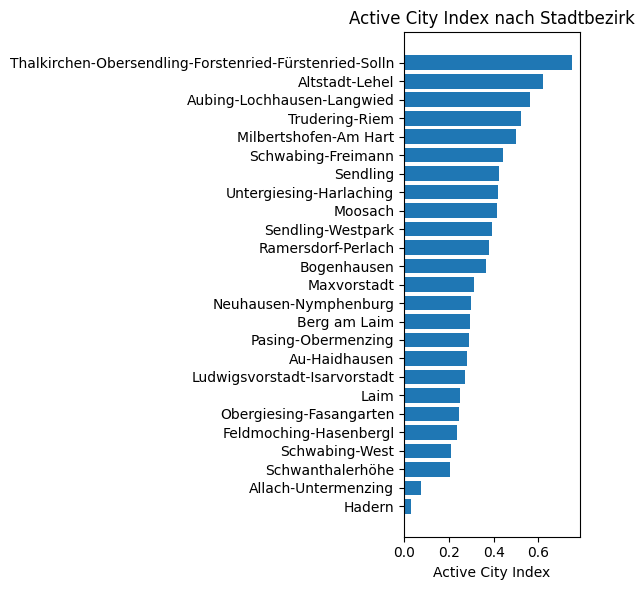

In [105]:
ordered = active_index[["name", "active_city_index"]].sort_values(
    "active_city_index", ascending=True
)

plt.figure(figsize=(6, 6))
plt.barh(ordered["name"], ordered["active_city_index"])
plt.xlabel("Active City Index")
plt.title("Active City Index nach Stadtbezirk")
plt.tight_layout()
plt.show()

### Räumliche Verteilung des Active City Index

Der Index wird als Choroplethenkarte auf Bezirksebene visualisiert, um räumliche Muster zu erkennen.

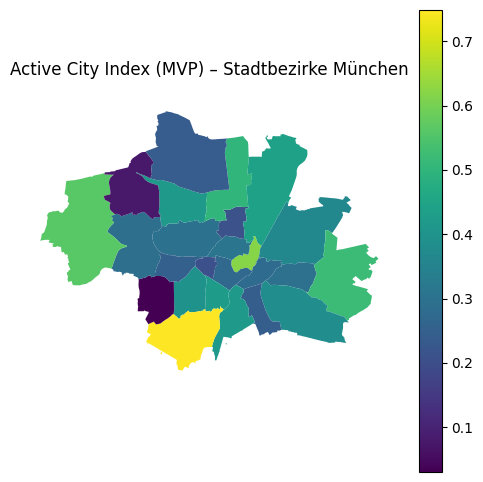

In [106]:
ax = active_index.plot(
    column="active_city_index",
    legend=True,
    figsize=(6, 6)
)
plt.title("Active City Index (MVP) – Stadtbezirke München")
plt.axis("off")
plt.show()

### Scatterplots & korrelationen

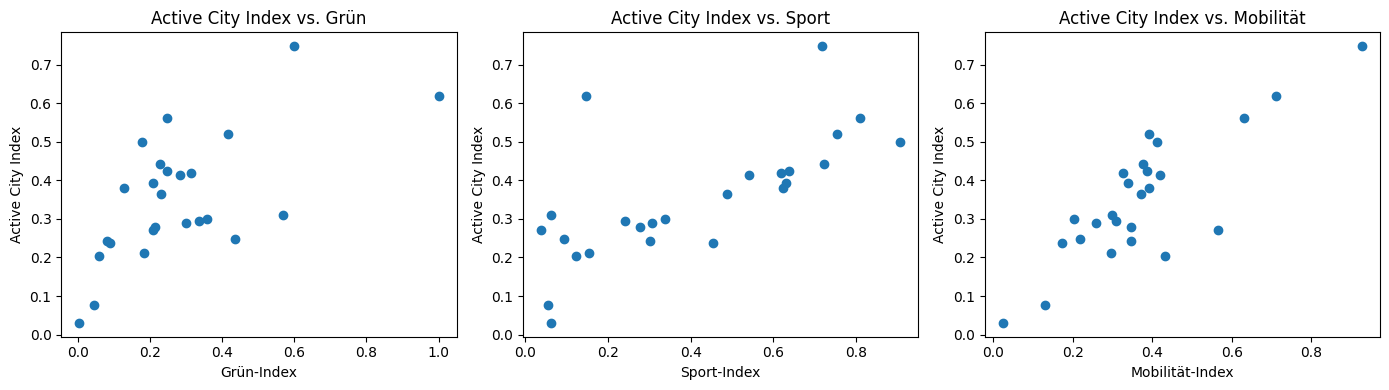

In [121]:
dims = ["index_gruen", "index_sport", "index_mobil"]
titles = ["Grün", "Sport", "Mobilität"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for col, title, ax in zip(dims, titles, axes):
    ax.scatter(active_index[col], active_index["active_city_index"])
    ax.set_xlabel(f"{title}-Index")
    ax.set_ylabel("Active City Index")
    ax.set_title(f"Active City Index vs. {title}")

plt.tight_layout()
plt.show()

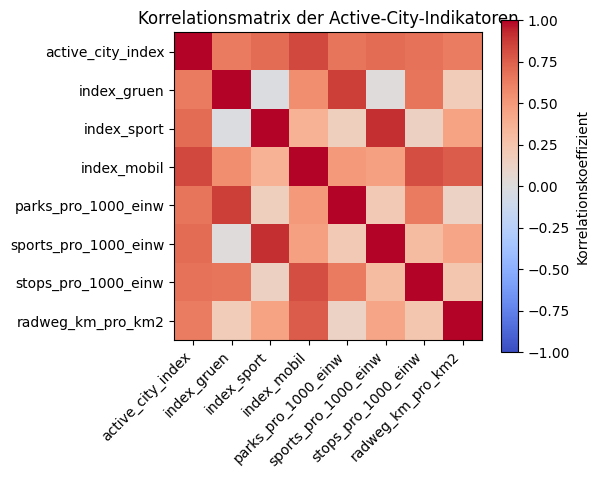

In [122]:
corr_cols = [
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil",
    "parks_pro_1000_einw",
    "sports_pro_1000_einw",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]

corr = active_index[corr_cols].corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Korrelationskoeffizient")

ax.set_title("Korrelationsmatrix der Active-City-Indikatoren")
plt.tight_layout()
plt.show()

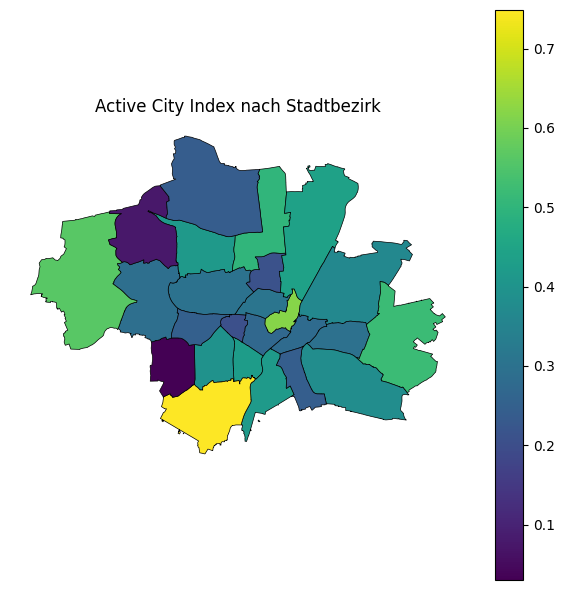

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
active_index.plot(
    column="active_city_index",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_axis_off()
ax.set_title("Active City Index nach Stadtbezirk")
plt.tight_layout()
plt.show()

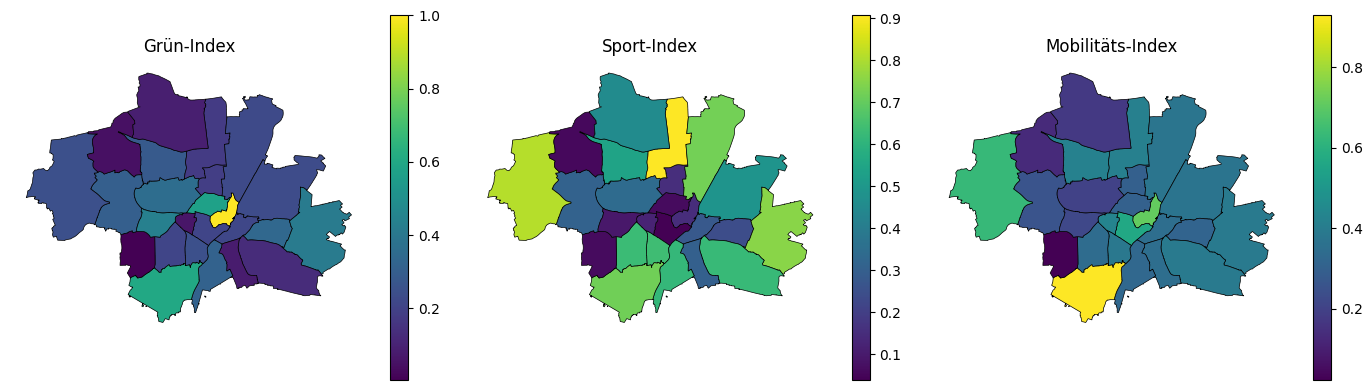

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for col, title, ax in zip(
    ["index_gruen", "index_sport", "index_mobil"],
    ["Grün-Index", "Sport-Index", "Mobilitäts-Index"],
    axes
):
    active_index.plot(
        column=col,
        cmap="viridis",
        legend=True,
        edgecolor="black",
        linewidth=0.5,
        ax=ax
    )
    ax.set_axis_off()
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [129]:
assert active_index["active_city_index"].between(0, 1).all()
assert active_index["index_gruen"].between(0, 1).all()
assert len(active_index) == 25  # 25 Stadtbezirke

## Sensitivitätsanalyse der Gewichtungen

In [130]:
# Sicherstellen, dass die drei Teilindizes existieren
for col in ["index_gruen", "index_sport", "index_mobil"]:
    assert col in active_index.columns, f"{col} fehlt in active_index"

# Basis-Index (equal weights) explizit als eigene Spalte ablegen
# falls active_city_index bereits der gleichgewichtete Index ist:
active_index["aci_equal"] = active_index["active_city_index"]

# Alternative Gewichtungsschemata:
# - Grün-fokussiert
# - Sport-fokussiert
# - Mobilitäts-fokussiert

active_index["aci_green_focus"] = (
    0.5  * active_index["index_gruen"] +
    0.25 * active_index["index_sport"] +
    0.25 * active_index["index_mobil"]
)

active_index["aci_sport_focus"] = (
    0.25 * active_index["index_gruen"] +
    0.5  * active_index["index_sport"] +
    0.25 * active_index["index_mobil"]
)

active_index["aci_mob_focus"] = (
    0.25 * active_index["index_gruen"] +
    0.25 * active_index["index_sport"] +
    0.5  * active_index["index_mobil"]
)

active_index[["name", "aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]].head()

,name,aci_equal,aci_green_focus,aci_sport_focus,aci_mob_focus
0,Altstadt-Lehel,0.619496,0.714622,0.501570,0.642297
1,Ludwigsvorstadt-Isarvorstadt,0.270103,0.254497,0.212162,0.343649
2,Maxvorstadt,0.310484,0.375239,0.248476,0.307736
3,Schwabing-West,0.211803,0.205024,0.197237,0.233147
4,Au-Haidhausen,0.279380,0.263277,0.278726,0.296136


In [132]:
# Spearmans Rangkorrelation zwischen den verschiedenen Index-Varianten

from scipy.stats import spearmanr

index_variants = ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]

print("Spearman-Rangkorrelationen der Indexvarianten:\n")

for var in index_variants[1:]:
    rho, p = spearmanr(active_index["aci_equal"], active_index[var])
    print(f"aci_equal vs {var}: ρ = {rho:.3f}, p = {p:.3f}")

Spearman-Rangkorrelationen der Indexvarianten:

aci_equal vs aci_green_focus: ρ = 0.982, p = 0.000
aci_equal vs aci_sport_focus: ρ = 0.956, p = 0.000
aci_equal vs aci_mob_focus: ρ = 0.973, p = 0.000


In [133]:
# Bezirke mit stärkster Rangverschiebung identifizieren
def rank_positions(df, score_col):
    """
    Gibt ein Dict {Bezirkname: Rangposition} zurück,
    Rang 1 = höchster Score.
    """
    ranking = (
        df[["name", score_col]]
        .sort_values(score_col, ascending=False)
        .reset_index(drop=True)
    )
    return {row["name"]: i + 1 for i, row in ranking.iterrows()}


# Rangpositionen für alle Varianten
ranks_equal       = rank_positions(active_index, "aci_equal")
ranks_green_focus = rank_positions(active_index, "aci_green_focus")
ranks_sport_focus = rank_positions(active_index, "aci_sport_focus")
ranks_mob_focus   = rank_positions(active_index, "aci_mob_focus")

def rank_diff_list(base_ranks, alt_ranks, label):
    diffs = []
    for name in base_ranks:
        diff = alt_ranks[name] - base_ranks[name]  # positiv = schlechterer Rang
        diffs.append((name, base_ranks[name], alt_ranks[name], diff))
    diffs_sorted = sorted(diffs, key=lambda x: abs(x[3]), reverse=True)
    print(f"\nTop 5 Rangverschiebungen für {label}:")
    for name, base_pos, alt_pos, diff in diffs_sorted[:5]:
        print(f"- {name}: von Rang {base_pos} auf Rang {alt_pos} (Δ = {diff})")

rank_diff_list(ranks_equal, ranks_green_focus, "Grün-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_sport_focus, "Sport-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_mob_focus,   "Mobilitäts-fokussierte Gewichtung")


Top 5 Rangverschiebungen für Grün-fokussierte Gewichtung:
- Maxvorstadt: von Rang 13 auf Rang 10 (Δ = -3)
- Laim: von Rang 19 auf Rang 16 (Δ = -3)
- Sendling: von Rang 7 auf Rang 9 (Δ = 2)
- Untergiesing-Harlaching: von Rang 8 auf Rang 6 (Δ = -2)
- Ramersdorf-Perlach: von Rang 11 auf Rang 13 (Δ = 2)

Top 5 Rangverschiebungen für Sport-fokussierte Gewichtung:
- Maxvorstadt: von Rang 13 auf Rang 19 (Δ = 6)
- Feldmoching-Hasenbergl: von Rang 21 auf Rang 15 (Δ = -6)
- Altstadt-Lehel: von Rang 2 auf Rang 6 (Δ = 4)
- Milbertshofen-Am Hart: von Rang 5 auf Rang 3 (Δ = -2)
- Pasing-Obermenzing: von Rang 16 auf Rang 14 (Δ = -2)

Top 5 Rangverschiebungen für Mobilitäts-fokussierte Gewichtung:
- Ludwigsvorstadt-Isarvorstadt: von Rang 18 auf Rang 13 (Δ = -5)
- Neuhausen-Nymphenburg: von Rang 14 auf Rang 18 (Δ = 4)
- Schwanthalerhöhe: von Rang 23 auf Rang 20 (Δ = -3)
- Moosach: von Rang 9 auf Rang 7 (Δ = -2)
- Laim: von Rang 19 auf Rang 21 (Δ = 2)


In [134]:
def top_n_for_variant(df, score_col, n=5):
    return (
        df[["bez_nr", "name", score_col]]
        .sort_values(score_col, ascending=False)
        .head(n)
        .reset_index(drop=True)
    )

print("Top 5 – equal weights:")
display(top_n_for_variant(active_index, "aci_equal"))

print("Top 5 – Grün-fokus:")
display(top_n_for_variant(active_index, "aci_green_focus"))

print("Top 5 – Sport-fokus:")
display(top_n_for_variant(active_index, "aci_sport_focus"))

print("Top 5 – Mobilitäts-fokus:")
display(top_n_for_variant(active_index, "aci_mob_focus"))

Top 5 – equal weights:


,bez_nr,name,aci_equal
0,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.748611
1,1,Altstadt-Lehel,0.619496
2,22,Aubing-Lochhausen-Langwied,0.562677
3,15,Trudering-Riem,0.520589
4,11,Milbertshofen-Am Hart,0.499102


Top 5 – Grün-fokus:


,bez_nr,name,aci_green_focus
0,1,Altstadt-Lehel,0.714622
1,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.711560
2,15,Trudering-Riem,0.494424
3,22,Aubing-Lochhausen-Langwied,0.484178
4,11,Milbertshofen-Am Hart,0.419011


Top 5 – Sport-fokus:


,bez_nr,name,aci_sport_focus
0,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.740761
1,22,Aubing-Lochhausen-Langwied,0.624273
2,11,Milbertshofen-Am Hart,0.600979
3,15,Trudering-Riem,0.578826
4,12,Schwabing-Freimann,0.511611


Top 5 – Mobilitäts-fokus:


,bez_nr,name,aci_mob_focus
0,19,Thalkirchen-Obersendling-Forstenried-Fürstenri...,0.793514
1,1,Altstadt-Lehel,0.642297
2,22,Aubing-Lochhausen-Langwied,0.579580
3,15,Trudering-Riem,0.488516
4,11,Milbertshofen-Am Hart,0.477315


### Export


In [135]:
export_cols = [
    # Basisinfos
    "bez_nr",
    "name",
    "einwohner",
    "flaeche_ha",
    "einwohnerdichte",
    
    # Rohindikatoren
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
    
    # Teilindizes
    "index_gruen",
    "index_sport",
    "index_mobil",
    
    # Gesamtindex + Varianten
    "active_city_index",
    "aci_equal",
    "aci_green_focus",
    "aci_sport_focus",
    "aci_mob_focus",
]

# Falls noch nicht in deiner Liste: geometry für Geo-Export
export_cols_with_geom = export_cols + ["geometry"]

In [136]:
# DataFrame ohne Geometrie
df_export = active_index[export_cols].copy()

output_csv = "../data/processed/muc_active_city_index.csv"

df_export.to_csv(
    output_csv,
    index=False,
    float_format="%.4f"  # rundet numerische Werte, z. B. 0.123456 -> 0.1235
)

output_csv

'../data/processed/muc_active_city_index.csv'

In [137]:
gdf_export = active_index[export_cols_with_geom].copy()

output_geojson = "../data/processed/muc_active_city_index.geojson"

gdf_export.to_file(
    output_geojson,
    driver="GeoJSON"
)

output_geojson

'../data/processed/muc_active_city_index.geojson'

In [138]:
output_gpkg = "../data/processed/muc_active_city_index.gpkg"

gdf_export.to_file(
    output_gpkg,
    layer="muc_active_index",
    driver="GPKG"
)

output_gpkg

'../data/processed/muc_active_city_index.gpkg'

## Robustheit: Leave one indicator out (LOO)

In [148]:
INDICATORS = {
    "green": ["parks_pro_1000_einw", "parks_area_anteil_prozent"],
    "sport": ["sports_pro_1000_einw", "sports_area_anteil_prozent"],
    "mob":   ["stops_pro_1000_einw", "radweg_km_pro_km2"],
}

base = compute_active_city_index(
    active_index.copy(),
    INDICATORS["green"],
    INDICATORS["sport"],
    INDICATORS["mob"],
    weights={"green": 1/3, "sport": 1/3, "mob": 1/3}
)

base_scores = base[["bez_nr", "name", "active_city_index"]].rename(
    columns={"active_city_index": "aci_base"}
)

In [151]:
from scipy.stats import spearmanr

results_leave_one_out = []

for dim, cols in INDICATORS.items():
    for col in cols:
        # Alle Indikatoren dieser Dimension OHNE col
        new_cols = cols.copy()
        new_cols.remove(col)

        gdf_tmp = compute_active_city_index(
            active_index.copy(),
            green_ind=INDICATORS["green"] if dim != "green" else new_cols,
            sport_ind=INDICATORS["sport"] if dim != "sport" else new_cols,
            mob_ind=INDICATORS["mob"]   if dim != "mob"   else new_cols,
        )

        tmp_scores = gdf_tmp[["bez_nr", "active_city_index"]].rename(
            columns={"active_city_index": "aci_loo"}
        )
        merged = base_scores.merge(tmp_scores, on="bez_nr")
        rho, _ = spearmanr(merged["aci_base"], merged["aci_loo"])

        results_leave_one_out.append({
            "dimension": dim,
            "removed_indicator": col,
            "spearman_rho": rho
        })

display(results_leave_one_out)

[{'dimension': 'green',
  'removed_indicator': 'parks_pro_1000_einw',
  'spearman_rho': np.float64(0.943076923076923)},
 {'dimension': 'green',
  'removed_indicator': 'parks_area_anteil_prozent',
  'spearman_rho': np.float64(0.9392307692307692)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_pro_1000_einw',
  'spearman_rho': np.float64(0.9653846153846154)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_area_anteil_prozent',
  'spearman_rho': np.float64(0.9569230769230769)},
 {'dimension': 'mob',
  'removed_indicator': 'stops_pro_1000_einw',
  'spearman_rho': np.float64(0.9469230769230769)},
 {'dimension': 'mob',
  'removed_indicator': 'radweg_km_pro_km2',
  'spearman_rho': np.float64(0.9284615384615384)}]

## Domains

In [152]:
DOMAIN_SCORES = {
    "green":  ["parks_pro_1000_einw_norm", "parks_area_anteil_prozent_norm"],
    "sport":  ["sports_pro_1000_einw_norm", "sports_area_anteil_prozent_norm"],
    "mob":    ["stops_pro_1000_einw_norm", "radweg_km_pro_km2_norm"],
}

for domain, cols in DOMAIN_SCORES.items():
    active_index[f"domain_{domain}"] = active_index[cols].mean(axis=1)

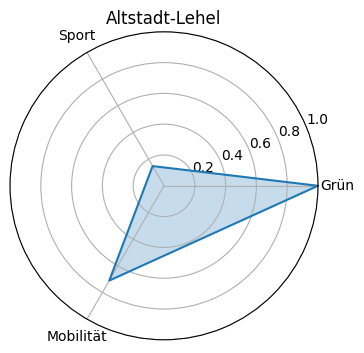

In [154]:
# Spinnenrad-Plot für einen Bezirk
import numpy as np

def plot_bezirk_profile(row):
    labels = ["Grün", "Sport", "Mobilität"]
    values = [
        row["index_gruen"],
        row["index_sport"],
        row["index_mobil"]
    ]
    values += values[:1]  # Radar close

    angles = np.linspace(0, 2*np.pi, len(labels) + 1)

    fig, ax = plt.subplots(subplot_kw={"polar": True}, figsize=(4, 4))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_title(row["name"])
    plt.show()

# Beispiel für einen Bezirk:
plot_bezirk_profile(active_index.iloc[0])